<a href="https://colab.research.google.com/github/ElzatAhmed/machine-learning-notes/blob/main/deep_reinforcement_learning_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 导入工具包
import torchvision
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# 定义全局变量
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

In [ ]:
# 利用 torchvision 获取 MNIST 数据集
train_dataset = torchvision.datasets.MNIST(
    './data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,)
                                   )
                               ])
)
test_dataset = torchvision.datasets.MNIST(
    './data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,)
                                   )
                               ])
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

此图对应的数据标签：5


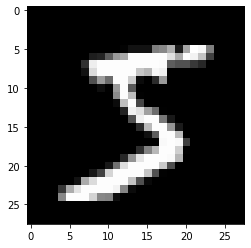

In [ ]:
plt.imshow(train_dataset[0][0][0], cmap="gray")   # 手写图
print(f'此图对应的数据标签：{train_dataset.targets[0].item()}')            # 对应标签

In [ ]:
torch.bincount(train_dataset.targets)   # 数据集中每一个数字对应的数量

tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

In [ ]:
# 利用DataLoader定义训练和测试数据集
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

In [ ]:
# 定义神经网络模型
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) 
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x)

In [ ]:
# 训练过程函数
def train(epoch, network, optimizer):
  train_losses = []
  train_counter = []
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    pred = network(data)
    loss = F.nll_loss(pred, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format( epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(loss.item()) 
    train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset))) 
    torch.save(network.state_dict(), './model.pth') 
    torch.save(optimizer.state_dict(), './optimizer.pth')

In [ ]:
# 测试过程函数
def test(network):
  network.eval()
  test_losses = []
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
network = Net()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
test(network)
for epoch in range(n_epochs):
  train(epoch, network, optimizer)
  test(network)
test(network)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2337, Accuracy: 100/10000 (1%)


Test set: Avg. loss: 0.2331, Accuracy: 209/10000 (2%)


Test set: Avg. loss: 0.2333, Accuracy: 322/10000 (3%)


Test set: Avg. loss: 0.2333, Accuracy: 428/10000 (4%)


Test set: Avg. loss: 0.2337, Accuracy: 527/10000 (5%)


Test set: Avg. loss: 0.2324, Accuracy: 673/10000 (7%)


Test set: Avg. loss: 0.2329, Accuracy: 793/10000 (8%)


Test set: Avg. loss: 0.2340, Accuracy: 899/10000 (9%)


Test set: Avg. loss: 0.2327, Accuracy: 1020/10000 (10%)


Test set: Avg. loss: 0.2328, Accuracy: 1137/10000 (11%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.360446
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.364010
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.329987
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.249067
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.288059
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.218085
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.214215
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.111192
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.092593
Train Ep

In [ ]:
# 上述训练方法在测试中得到了97%的精确度
# 接下来对参数进行修改
n_epochs = 10
log_interval = 100
learning_rate = 0.001
network = Net()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
test(network)
for epoch in range(n_epochs):
  train(epoch, network, optimizer)
  test(network)
test(network)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2297, Accuracy: 93/10000 (1%)


Test set: Avg. loss: 0.2303, Accuracy: 165/10000 (2%)


Test set: Avg. loss: 0.2295, Accuracy: 253/10000 (3%)


Test set: Avg. loss: 0.2303, Accuracy: 328/10000 (3%)


Test set: Avg. loss: 0.2301, Accuracy: 415/10000 (4%)


Test set: Avg. loss: 0.2302, Accuracy: 491/10000 (5%)


Test set: Avg. loss: 0.2301, Accuracy: 590/10000 (6%)


Test set: Avg. loss: 0.2302, Accuracy: 663/10000 (7%)


Test set: Avg. loss: 0.2302, Accuracy: 747/10000 (7%)


Test set: Avg. loss: 0.2302, Accuracy: 822/10000 (8%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.315577
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.811030
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.483429
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.418074
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.326385
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.382026
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.435960
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.326793
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.2203